In [31]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
from scipy.io import wavfile

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [5.333, 3]
plt.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans','Lucida Grande', 'Verdana']

TAU = 2 * np.pi  

In [32]:
class Delay:
    def __init__(self, sample_rate, delay_ms, delay_samples=None):
        if delay_samples:
            self.delay_length = delay_samples
        else:
            self.delay_length = int(delay_ms * (sample_rate / 1000.0))
        self.delay_line = deque(np.zeros(self.delay_length), self.delay_length)
        self.output = 0.0
        
    
    def tick(self, input):
        self.output = self.delay_line[-1]
        self.delay_line.appendleft(input)


    def clear(self):
        for sample in range(self.delay_length + 1):
            self.delay_line.appendleft(0.0)

class AllPassDelay:
    def __init__(self, sample_rate, delay_ms, coeff, linear=True, nonlinearity=np.tanh):
        self.delay = Delay(sample_rate, delay_ms)
        self.nonlinearity = nonlinearity
        self.g = coeff
        self.linear = linear
        self.output = 0.0
        
    
    def tick(self, input):
        delay_input = input + self.g * self.delay.output
        self.output = (-1.0 * self.g * delay_input) + ((1.0 - self.g**2) * self.delay.output)

        if not self.linear:
            self.output = self.nonlinearity(self.output)

        self.delay.tick(delay_input)
        

    def clear(self):
        self.delay.clear()


In [33]:
class SchroederReverb:
    def __init__(self, gain_1, gain_2, size, delay_length, allpass_lengths, allpass_coeffs, sample_rate):
        assert len(allpass_lengths) == size
        assert len(allpass_coeffs) == size
        self.size = size
        self.gain_1 = gain_1
        self.gain_2 = gain_2

        self.allpass_reverb = []
        for allpass in range(size):
            self.allpass_reverb.append(AllPassDelay(sample_rate,
                                                    allpass_lengths[allpass],
                                                    allpass_coeffs[allpass]))

        self.delay = Delay(sample_rate, delay_length)


    def tick(self, input):
        self.delay.tick(input + self.gain_2 * self.allpass_reverb[-1].output)
        for index, allpass in enumerate(self.allpass_reverb):
            if index == 0:
                allpass.tick(self.delay.output)
            else:
                allpass.tick(self.allpass_reverb[index - 1].output)

        output = (self.allpass_reverb[-1].output * (1.0 - self.gain_1**2)) + (input * self.gain_1 * -1.0)
        return output
    

    def clear(self):
        self.delay.clear()
        for allpass in self.allpass_reverb:
            allpass.clear()

In [34]:
allpass_lengths = [11, 7, 19, 3, 23]
allpass_coeffs = [0.5, 0.5, 0.5, 0.5, 0.5]
delay_length = 43

sample_rate, data = wavfile.read("./input.wav")

reverb = SchroederReverb(0.33, 2.2, 5, delay_length, allpass_lengths, allpass_coeffs, sample_rate)

input = data
output = np.zeros(input.size)

for index, sample in enumerate(input):
    output[index] = reverb.tick(sample)
    
data = output

wavfile.write("output.wav", sample_rate, data.astype(np.int16))


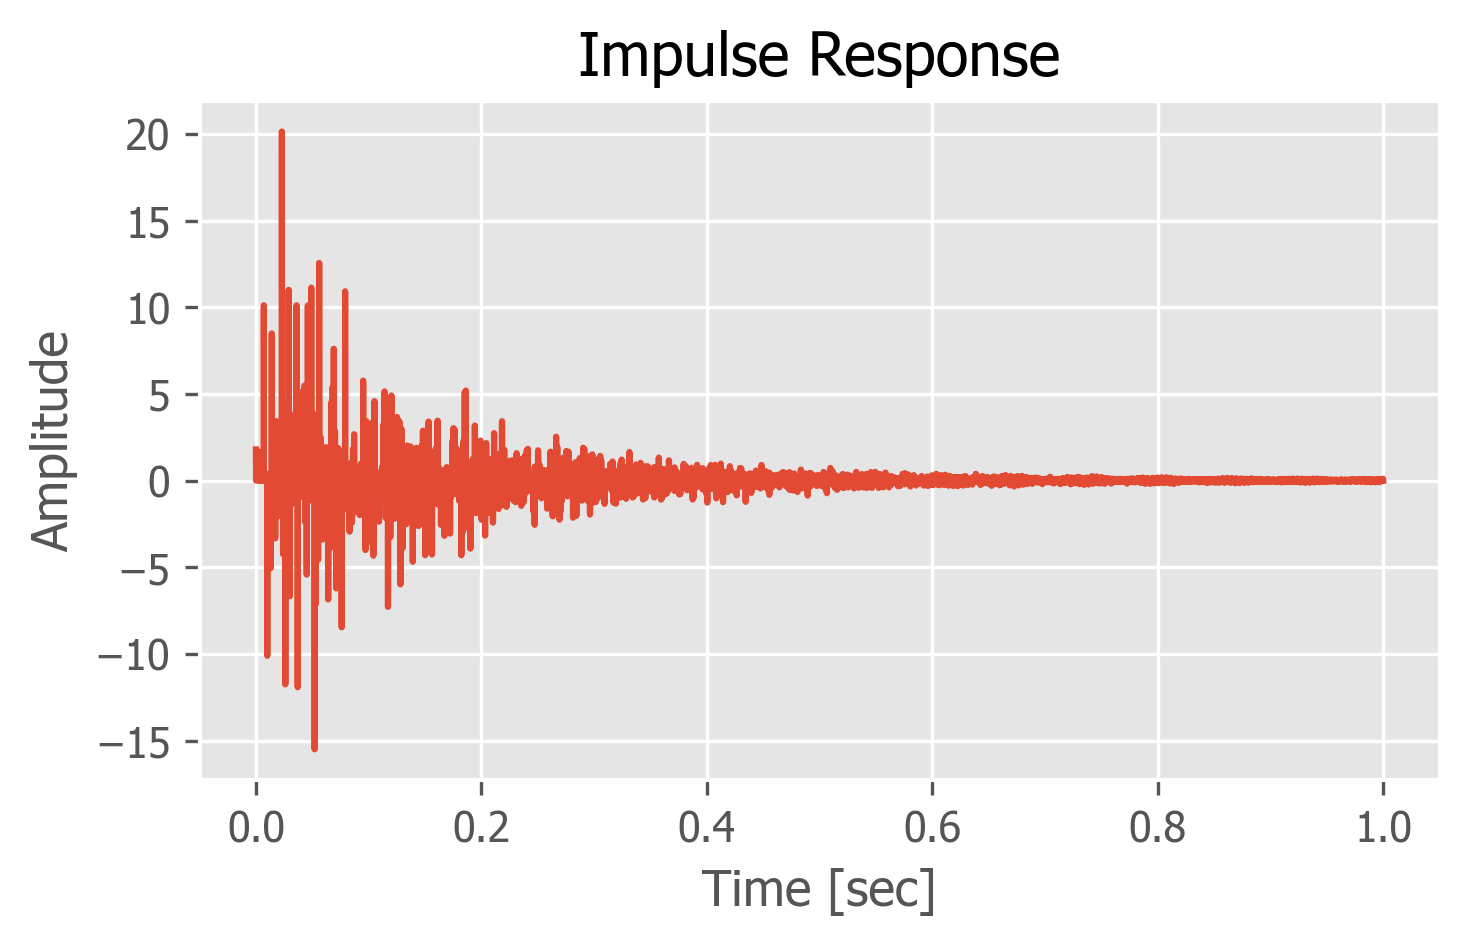

In [35]:
reverb.clear()

time = 1.0
samples = int(time * sample_rate)
x = np.linspace(0.0, time, samples, endpoint=False)
impulse = signal.unit_impulse(x.size)

input = impulse
output = np.zeros(input.size)
for index, sample in enumerate(input):
    output[index] = reverb.tick(sample)

plt.plot(x, output)
plt.title('Impulse Response')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.show()

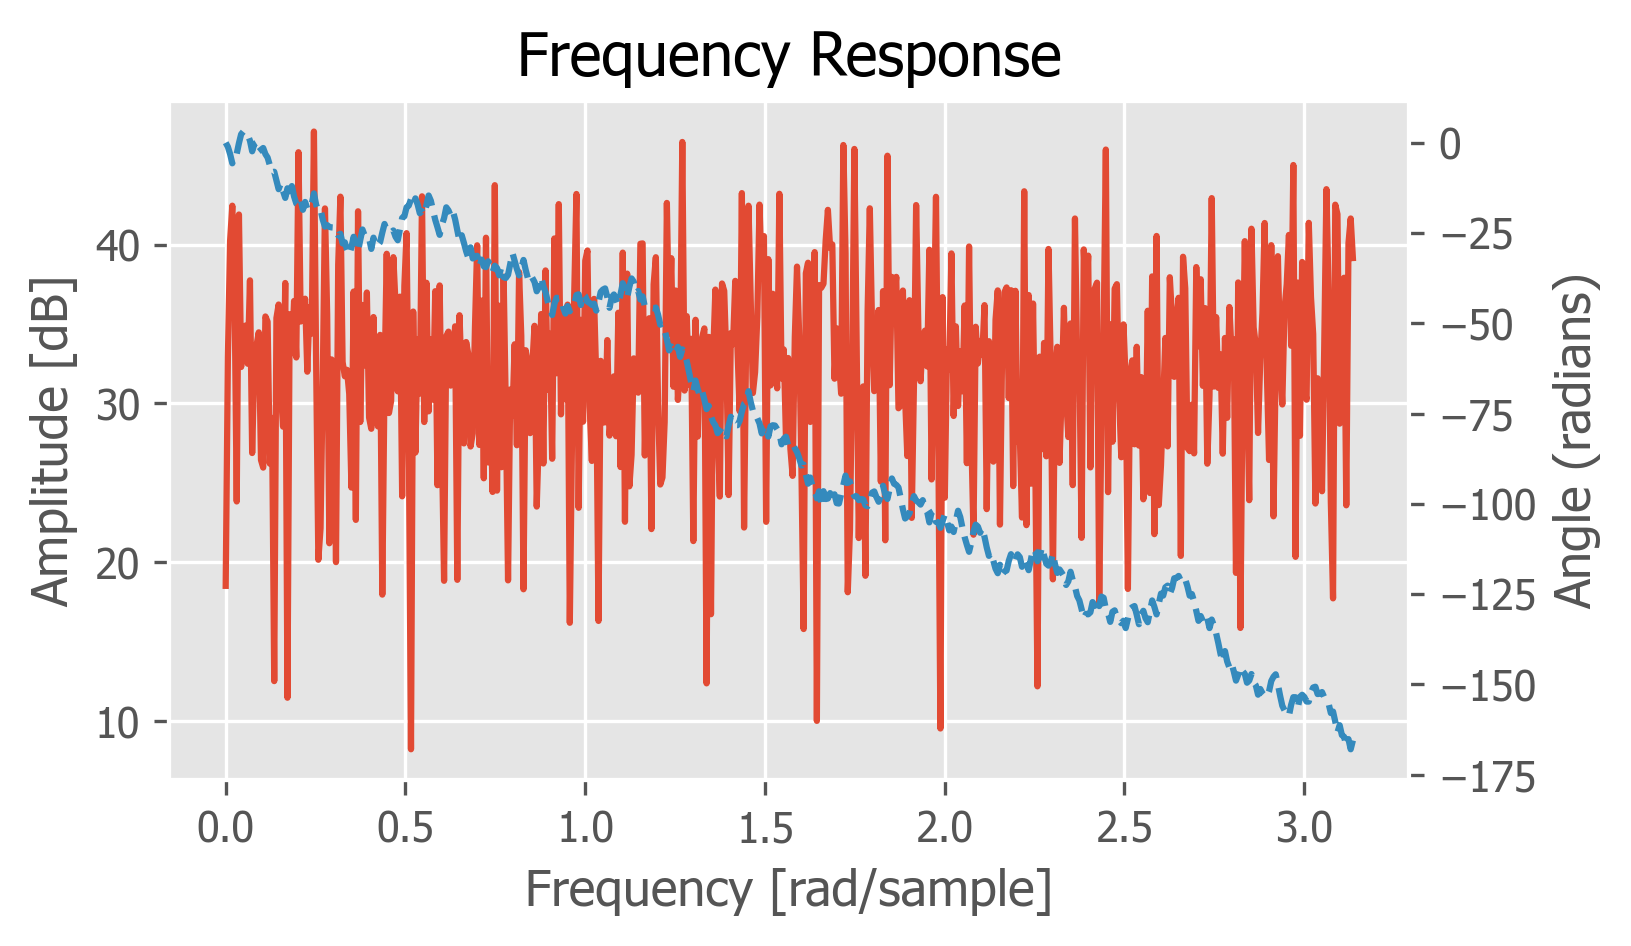

In [36]:
w, h = signal.freqz(output)
fig, ax1 = plt.subplots()

ax1.set_title('Frequency Response')
ax1.plot(w, 20 * np.log10(abs(h)), 'C0-')
ax1.set_ylabel('Amplitude [dB]')
ax1.set_xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles,'C1--')
ax2.set_ylabel('Angle (radians)')
ax2.grid()
ax2.axis('tight')

plt.show()